In [1]:
# load the rpy2 extension
%load_ext rpy2.ipython

In [2]:
%matplotlib inline
import pyodbc                # Needed to connect to ODBC data sources
import crypto, codecs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')
pd.set_option("display.max_rows",1000)

key = codecs.escape_decode(open(r'D:\webapps\_server\pyodbc\key', 'r').read())[0]
pw_file = open(r'D:\webapps\_server\pyodbc\cmq.txt', 'r')
pwd = pw_file.read()
pw = crypto.decrypt_with_key(key, pwd)
userid = 'rb10'
pw_file.close()

cnxn_string = 'DSN=CMQ_PROD;UID=' + userid + ';PWD=' + pw

cnxn = pyodbc.connect(cnxn_string)
cursor = cnxn.cursor()

# Get the necessary input from the user
year      = input("Enter model year(s) separated by comma: ")
factory   = input("Enter factory code(s) separated by comma: ").upper()
model     = input("Enter model name(s) separated by comma: ").upper()
dest_code = input("Enter destination code(s) separated by comma: ").upper()
part      = input("Enter part number(s) separated by comma: ")

from datetime import datetime
start = datetime.now()

# Make a list for each parameter input
years      = year.split(',')
factories  = factory.split(',')
models     = model.split(',')
dest_codes = dest_code.split(',')
parts      = part.split(',')

# Now get the number of items in each list so that we can properly use the .join() function below
Y = len(years)       # The number of years the user entered
F = len(factories)   # The number of factories the user entered
M = len(models)      # The number of models the user entered
D = len(dest_codes)  # The number of destination codes the user entered
P = len(parts)       # The number of part numbers the user entered

sql = """
WITH VEHICLES as (
SELECT
VIN_SK

FROM CMQ.V_FACT_VHCL_PRDN_SLS prod

INNER join CMQ.V_DIM_MTO MTO
ON prod.mto_sk = mto.mto_sk

WHERE
MTO.MDL_YR IN(%s)
AND MTO.FCTRY_CD IN(%s)
AND MTO.MDL_NM IN(%s)
AND MTO.DEST_CD IN(%s)
),

CLAIMS AS (
SELECT
CLAIMS.CLM_SK,
CLAIMS.VIN_SK

FROM CMQ.V_FACT_CLM_TRX CLAIMS

INNER JOIN CMQ.V_DIM_CLM CLAIM_DETAILS
ON CLAIMS.CLM_SK = CLAIM_DETAILS.CLM_SK

INNER JOIN CMQ.V_DIM_MTO MTO
ON CLAIMS.MTO_SK = MTO.MTO_SK

INNER JOIN CMQ.V_DIM_PART FAIL_PART
ON CLAIMS.FAIL_PART_SK = FAIL_PART.PART_SK

INNER JOIN CMQ.V_DIM_SUBL_CD SUBLET1
ON CLAIMS.SUBL_01_SK = SUBLET1.SUBL_CD_SK

INNER JOIN CMQ.V_DIM_SUBL_CD SUBLET2
ON CLAIMS.SUBL_02_SK = SUBLET2.SUBL_CD_SK

WHERE
MTO.MDL_YR IN(%s)
AND MTO.FCTRY_CD IN(%s)
AND MTO.MDL_NM IN(%s)
AND MTO.DEST_CD IN(%s)
AND CLAIMS.CAMP_SK <= 0
AND NOT LEFT(CLAIM_DETAILS.CLM_NO,1) IN ('T', 'R')
AND NOT LEFT(FAIL_PART.PART_NO,2) = '08'
AND NOT FAIL_PART.SHRT_PART_NO IN ('TCHV','TCAV')
AND NOT SUBLET1.SUBL_CD = 'GW'
AND NOT SUBLET2.SUBL_CD = 'GW'
),

REPLACED as (
SELECT
REPLPART.CLM_SK

FROM CMQ.V_FACT_CLM_REPL_PART REPLPART

INNER JOIN CLAIMS CLAIMS
ON REPLPART.CLM_SK = CLAIMS.CLM_SK

INNER JOIN CMQ.V_DIM_PART PART
ON PART.PART_SK = REPLPART.REPL_PART_SK

WHERE
PART.SHRT_PART_NO IN(%s)
AND REPLPART.REPL_PART_QTY > 0
AND REPLPART.ADJ_PART_QTY > 0
AND REPLPART.VHCL_DEST_CD IN(%s)
),

claims_unique as (
SELECT
MIN(REPLACED.CLM_SK) as CLM_SK,
CLAIMS.VIN_SK

FROM claims claims

INNER JOIN REPLACED REPLACED ON
CLAIMS.CLM_SK = REPLACED.CLM_SK

GROUP BY
CLAIMS.VIN_SK
)

SELECT
MDL_YR,
FCTRY_CD,
MDL_NM,
AF_MTH,
RO_MTH,
SUM(SALE_QTY) AS SALE_QTY,
SUM(VEH_QTY) AS VEH_QTY,
SUM(CLAIM_QTY) AS CLAIM_QTY,
SUM(CLAIM_AMT) AS CLAIM_AMT

FROM (
    SELECT
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    SUM(SALE_QTY) AS SALE_QTY,
    SUM(VEH_QTY) AS VEH_QTY,
    SUM(CLAIM_QTY) AS CLAIM_QTY,
    SUM(CLAIM_AMT) AS CLAIM_AMT

    FROM (
        SELECT
        MTO.MDL_YR AS MDL_YR,
        MTO.FCTRY_CD AS FCTRY_CD,
        MTO.MDL_NM AS MDL_NM,
        AF_CAL.CAL_YR_MO_FMT_NO AS AF_MTH,
        SALE_CAL.CAL_YR_MO_FMT_NO AS RO_MTH,

        CASE
        WHEN PROD.RTL_SLS_DT_SK > 0
        THEN 1
        ELSE 0
        END AS SALE_QTY,

        1 AS VEH_QTY,
        0 AS CLAIM_QTY,
        0 AS CLAIM_AMT

        FROM VEHICLES VEHICLES

        INNER JOIN CMQ.V_FACT_VHCL_PRDN_SLS PROD
        ON VEHICLES.VIN_SK = PROD.VIN_SK

        INNER JOIN CMQ.V_DIM_MTO MTO
        ON PROD.MTO_SK = MTO.MTO_SK
        
        INNER JOIN CMQ.V_DIM_DATE AF_CAL
        ON PROD.AF_OFF_DT_SK = AF_CAL.CAL_DT_SK

        INNER JOIN CMQ.V_DIM_DATE SALE_CAL
        ON PROD.RTL_SLS_DT_SK = SALE_CAL.CAL_DT_SK

        WHERE
        VEHICLES.VIN_SK IS NOT NULL

    ) AS VEH

    GROUP BY
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH

    UNION

    SELECT
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH,
    SUM(SALE_QTY) AS SALE_QTY,
    SUM(VEH_QTY) AS VEH_QTY,
    SUM(CLAIM_QTY) AS CLAIM_QTY,
    SUM(CLAIM_AMT) AS CLAIM_AMT

    FROM (
        SELECT
        MTO.MDL_YR AS MDL_YR,
        MTO.FCTRY_CD AS FCTRY_CD,
        MTO.MDL_NM AS MDL_NM,
        AF_CAL.CAL_YR_MO_FMT_NO AS AF_MTH,
        RO_CAL.CAL_YR_MO_FMT_NO AS RO_MTH,

        0 AS SALE_QTY,

        0 AS VEH_QTY,
        1 AS CLAIM_QTY,
        FCLAIMS.USD_REMB_CLM_AMT AS CLAIM_AMT

        FROM CLAIMS_UNIQUE CLAIMS_UNIQUE

        INNER JOIN REPLACED
        ON CLAIMS_UNIQUE.CLM_SK = REPLACED.CLM_SK

        INNER JOIN CMQ.V_FACT_VHCL_PRDN_SLS PROD
        ON CLAIMS_UNIQUE.VIN_SK = PROD.VIN_SK

        INNER JOIN CMQ.V_FACT_CLM_TRX FCLAIMS
        ON CLAIMS_UNIQUE.CLM_SK = FCLAIMS.CLM_SK

        INNER JOIN CMQ.V_DIM_MTO MTO
        ON PROD.MTO_SK = MTO.MTO_SK
        
        INNER JOIN CMQ.V_DIM_DATE AF_CAL
        ON PROD.AF_OFF_DT_SK = AF_CAL.CAL_DT_SK

        INNER JOIN CMQ.V_DIM_DATE RO_CAL
        ON FCLAIMS.RO_DT_SK = RO_CAL.CAL_DT_SK

        WHERE
        CLAIMS_UNIQUE.CLM_SK IS NOT NULL

    ) AS CLM

    GROUP BY
    MDL_YR,
    FCTRY_CD,
    MDL_NM,
    AF_MTH,
    RO_MTH

) AS FINAL

GROUP BY
MDL_YR,
FCTRY_CD,
MDL_NM,
AF_MTH,
RO_MTH
""" % (",".join("?" * Y), ",".join("?" * F), ",".join("?" * M), ",".join("?" * D), 
       ",".join("?" * Y), ",".join("?" * F), ",".join("?" * M), ",".join("?" * D), 
       ",".join("?" * P), ",".join("?" * D))

parameter_list = []
for year in years:
    parameter_list.append(year)
    
for factory in factories:
    parameter_list.append(factory)

for model in models:
    parameter_list.append(model)
    
for code in dest_codes:
    parameter_list.append(code)
    
for year in years:
    parameter_list.append(year)
    
for factory in factories:
    parameter_list.append(factory)

for model in models:
    parameter_list.append(model)
    
for code in dest_codes:
    parameter_list.append(code)
    
for p in parts:
    parameter_list.append(p)
    
for code in dest_codes:
    parameter_list.append(code)

df = pd.read_sql(sql, cnxn, index_col=None, params=parameter_list)

# Close connections
cursor.close()
cnxn.close()

# Exclude unsold units
df = df[df['RO_MTH']!='9999-12']

df['LABEL'] = df['MDL_YR'].map(str) + '-' + df['MDL_NM'].map(str) + '-' +df['FCTRY_CD'].map(str)

##################################  RO Section ##############################
cum_sales = pd.pivot_table(df,values='SALE_QTY',index='RO_MTH',columns=['LABEL'],aggfunc=np.sum).cumsum()

# Forward fill missing values
cum_sales.fillna(method='ffill', inplace=True)

# Get Column headers
categories = cum_sales.columns

cum_sales.columns = [column + ' Cum Sales' for column in cum_sales.columns]

# Create cumulative claims table and rename column names
cum_claims = pd.pivot_table(df,values='CLAIM_QTY',index='RO_MTH',columns=['LABEL'],aggfunc=np.sum).cumsum()
cum_claims.fillna(method='ffill', inplace=True)  # Forward fill missing values
cum_claims.columns = [column + ' Cum Claims' for column in cum_claims.columns]

left_joined = pd.merge(cum_sales,cum_claims,how='left',left_index=True,right_index=True)

# Dynamically create cum defect rate columns and column names
i = 0
header_size = len(categories)
while i < header_size:
    for label in categories:
        left_joined[label + ' Cum Defect Rate'] = left_joined.iloc[:,i+header_size] / left_joined.iloc[:,i] * 100
        i = i + 1

# create a dataframe with columns containing the word 'Defect'
ro_defect_rates = left_joined.filter(like='Defect')

# Convert index to column
ro_defect_rates.reset_index(level=0, inplace=True)

# Convert data from wide format to long format and rename columns so that we can plot using ggplot
ro_df_long = pd.melt(ro_defect_rates, id_vars=['RO_MTH']).dropna()
ro_df_long.rename(columns={'variable':'YR_MDL_FAC','value':'Def_Rate'}, inplace=True)

# Create MFSS values
grouped = ro_df_long['YR_MDL_FAC'].value_counts()
grouped = grouped.sort_index()  # Ensure the groups are sorted by YR-MDL-FAC
new_index_list = [[value for value in range(index)] for index in grouped.values]

new_index = []
for mylist in new_index_list:
    new_index = new_index + mylist
    
ro_df_long.index = new_index

# Create a column from the index values and rename
ro_df_long.reset_index(level=0, inplace=True)
ro_df_long.rename(columns={'index':'MFSS'}, inplace=True)



##################################  AF Section  #############################
af_sales = pd.pivot_table(df,values='SALE_QTY',index='AF_MTH',columns=['LABEL'],aggfunc=np.sum)

# Get Column headers
categories = af_sales.columns

# Rename column headers
af_sales.columns = [column + ' Sales' for column in categories]

# Pivot table of claims by AF mth
af_claims = pd.pivot_table(df,values='CLAIM_QTY',index='AF_MTH',columns=['LABEL'],aggfunc=np.sum)

# Rename column headers
af_claims.columns = [column + ' Claims' for column in categories]

# Left join
af_left_joined = pd.merge(af_sales, af_claims, how='left', left_index=True, right_index=True)

# Dynamically create cum defect rate columns and column names
i = 0
header_size = len(categories)
while i < header_size:
    for label in categories:
        af_left_joined[label + ' Defect Rate'] = af_left_joined.iloc[:,i+header_size] / af_left_joined.iloc[:,i] * 100
        i = i + 1
        
# create a dataframe with columns containing the word 'Defect'
af_defect_rates = af_left_joined.filter(like='Defect')

# Convert index to column
af_defect_rates.reset_index(level=0, inplace=True)

# Convert data from wide format to long format and rename columns so that we can plot using ggplot
af_df_long = pd.melt(af_defect_rates, id_vars=['AF_MTH']).dropna()
af_df_long.rename(columns={'variable':'YR_MDL_FAC','value':'Def_Rate'}, inplace=True)

Enter model year(s) separated by comma: 2012,2013,2014,2015
Enter factory code(s) separated by comma: hma,hcm
Enter model name(s) separated by comma: mdx
Enter destination code(s) separated by comma: ka,kl
Enter part number(s) separated by comma: 35750,35760


In [15]:
%R -i ro_df_long
%R -i af_df_long

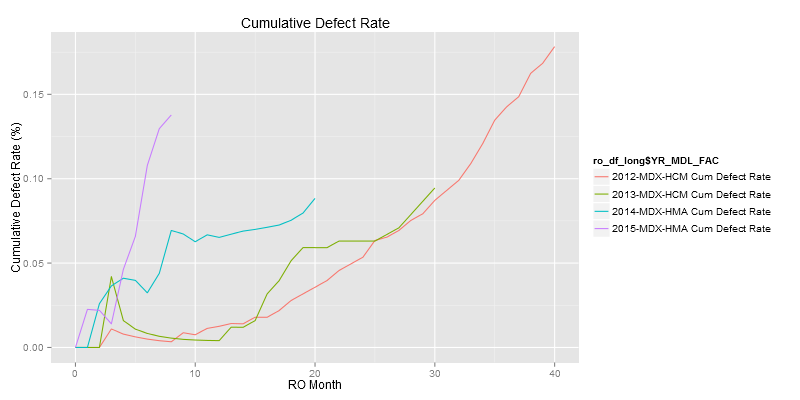

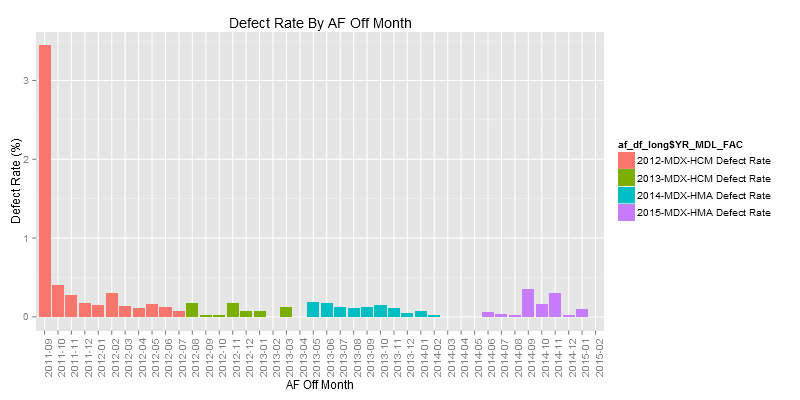

In [17]:
%%R -w 800 -h 400 -u px # instead of px, you can also choose 'in', 'cm', or 'mm'
df <- as.data.frame(ro_df_long)
df <- as.data.frame(af_df_long)
library(ggplot2)        # plotting library

ro <- ggplot(ro_df_long, aes(ro_df_long$MFSS, ro_df_long$Def_Rate, color=ro_df_long$YR_MDL_FAC))
ro <- ro + 
    geom_line() +
    ggtitle("Cumulative Defect Rate") +
    xlab("RO Month") +
    ylab("Cumulative Defect Rate (%)")
print(ro)

af <- ggplot(af_df_long, aes(af_df_long$AF_MTH, af_df_long$Def_Rate, fill=af_df_long$YR_MDL_FAC))
af <- af +
    geom_bar(stat="identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    ggtitle("Defect Rate By AF Off Month") +
    xlab("AF Off Month") +
    ylab("Defect Rate (%)")
print(af)